## ControlNet이란?
Stable Diffusion은 텍스트 프롬프트 또는 입력 이미지를 통하여 이미지를 생성하지만 생성된 이미지를 원하는 대로 출력하기 어렵습니다. 아무리 프롬프트를 자세하게 써도 생성되는 이미지가 내가 원하는 자세, 구도, 배경을 갖도록 하는 것은 거의 불가능하죠. ControlNet은 Diffusion 모델에 추가 조건을 추가하여 출력되는 이미지를 쉽게 제어할 수 있습니다. 뿐만 아니라 ControlNet은 훈련 데이터가 작아도 학습이 잘 되고 빠르다는 장점이 있어 개인용 기기에서 사용할 수 있다는 장점이 있습니다.

ControlNet은 논문 'Adding Conditional Control to Text-to-Image Diffusion Models'에서 소개되었고, 외곽선 감지(Canny Edge detection), 인체 자세 감지(Human pose), 낙서 지도(Scribble map), 시맨틱 세그멘테이션(Semantic segmentation) 등 다양한 전처리기(Preprocessor)를 Stable Diffusion 모델에 도입할 수 있습니다. 그래서 원하는 자세, 구도 등으로 이미지를 생성할 수 있습니다.

ControlNet을 사용하여 이미지에 조건을 주어 이미지를 다양하게 변형

In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

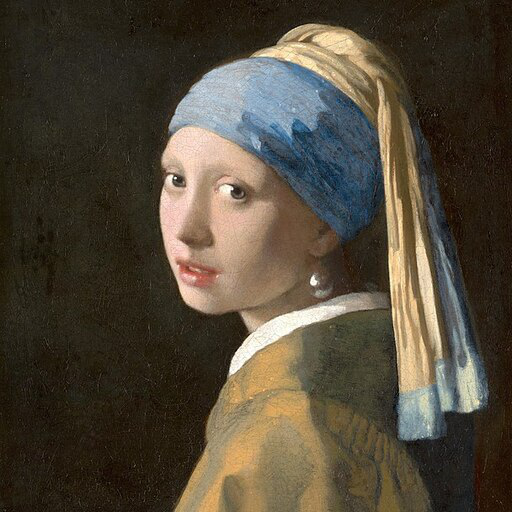

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

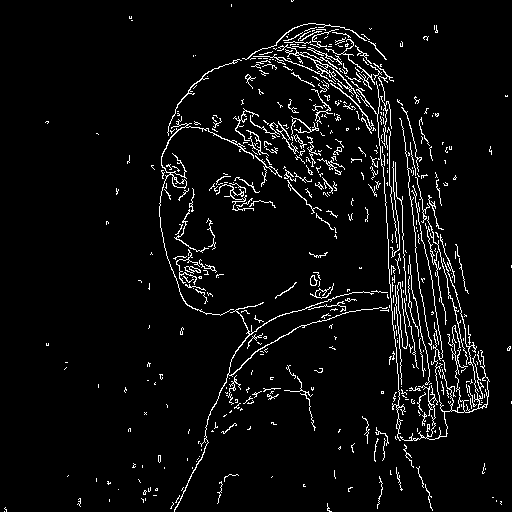

In [3]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [4]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

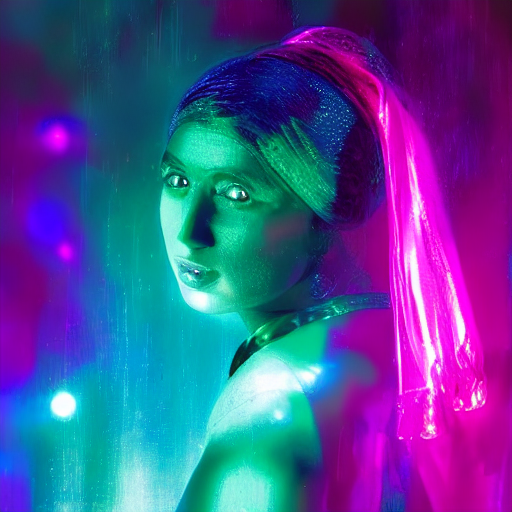

In [5]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

프롬프트 외에도 부정적인 프롬프트(negative_propmt)를 넣을 수도 있고, 하이퍼파라미터를 조절할 수도 있습니다.

negative_propmt: 원하지 않는 요소를 적을 수 있습니다.
controlnet_conditioning_scale: ContorlNet으로 조건을 어느 정도 주느냐를 조절합니다. Default는 1이고, 실수값으로 설정할 수 있습니다.
num_inference_steps: 추론 횟수로, 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸립니다. default 값은 50입니다.
guidance_scale: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터로, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있습니다. default는 7.5입니다.

## 인체 자세 감지
Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리기입니다. 자세를 감지하여 새로운 이미지를 생성해 줍니다.

먼저 사람의 전신이 담긴 이미지를 불러오겠습니다.

In [6]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

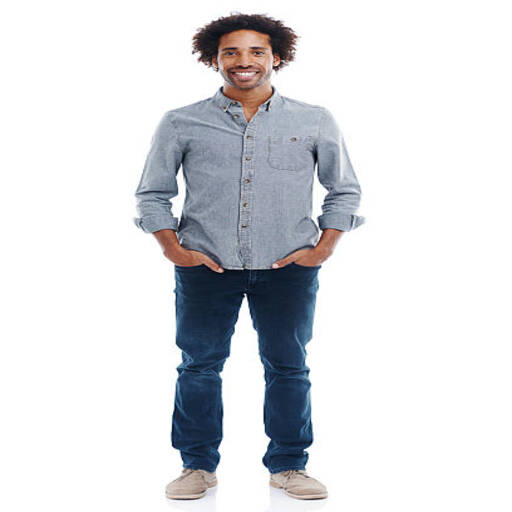

In [7]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

Openpose 검출기를 사용하면 자세만 추출할 수 있습니다.

cuda


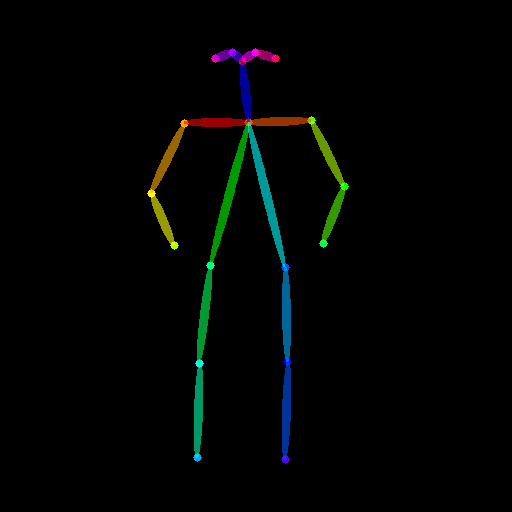

In [8]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

Openpose 전처리기를 사용한 모델 파이프라인을 불러옵니다.

In [9]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

새로운 이미지를 생성해 보겠습니다. Canny Edge Detection에서 사용한 코드를 참고하여 여러분들이 직접 코드를 작성해 보세요. 하이퍼파라미터를 조절하면 더 멋진 이미지를 생성할 수 있을 거에요.

  0%|          | 0/50 [00:00<?, ?it/s]

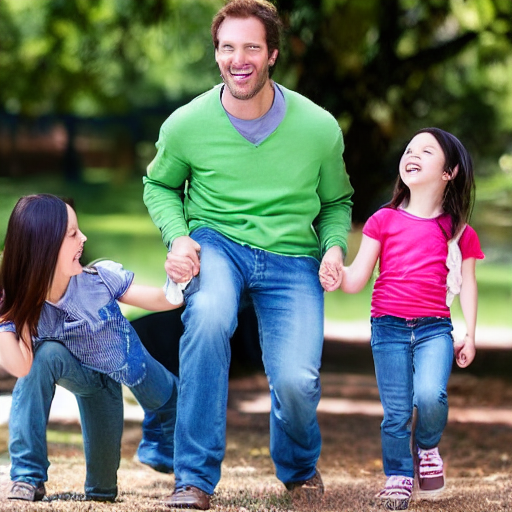

In [10]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

openpose_pipe

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 프롬프트를 작성합니다.
prompt = "A happy family in a park"
negative_prompt = "No sad expressions"

# 이미지를 생성합니다.
openpose_image1 = openpose_pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=50, generator=generator, image=openpose_image).images[0]

# 생성된 이미지를 출력합니다.
openpose_image1

  0%|          | 0/60 [00:00<?, ?it/s]

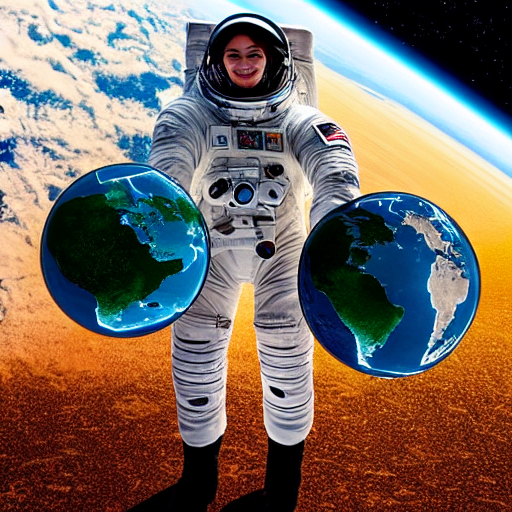

In [11]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 
# 새로운 프롬프트와 네거티브 프롬프트 설정
prompt = "An astronaut floating in space with Earth in the background"
negative_prompt = "No dark, scary themes"

# 이미지 생성
num_inference_steps = 60  # 생성 과정의 단계 수를 조절
openpose_image1 = openpose_pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt, 
    num_inference_steps=num_inference_steps, 
    generator=generator, 
    image=openpose_image
).images[0]

# 생성된 이미지 출력
openpose_image1

## 윤곽선 검출 + 인체 자세 감지
이번에는 위에서 실습한 2가지의 전처리기를 동시에 사용해 보겠습니다. 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달하면 됩니다.

Canny 알고리즘을 사용한 윤곽선 검출
먼저 Canny 알고리즘으로 윤곽선을 검출합니다. Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검출 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다는 점을 주의하세요.

In [12]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
canny_image_url = "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
canny_image = load_image(canny_image_url)

# threshold를 지정합니다.
low_threshold = 50
high_threshold = 150

# 이미지를 NumPy 배열로 변환합니다.
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

## Openpose를 사용한 인체 자세 검출
인체 자세를 검출해 줍니다.

In [13]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다.
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# OpenposeDetector를 초기화합니다.
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# OpenposeDetector를 사용하여 이미지에서 인체 자세를 검출합니다.
openpose_image = openpose(openpose_image)

cuda


Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달합니다.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

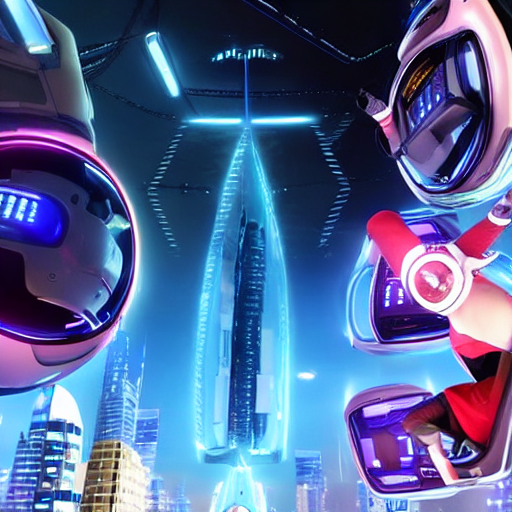

In [14]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnets = [canny_controlnet, openpose_controlnet]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt = "A futuristic cityscape with flying cars"
negative_prompt = "No old-fashioned buildings"

# seed를 지정합니다.
generator = torch.manual_seed(0)

images = [openpose_image, canny_image]

# 이미지를 생성합니다.
image = pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=50, generator=generator, image=images).images[0]

# 생성된 이미지를 저장합니다.
image.save("/aiffel/aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.
image

## 회고

짧은코드로 이미지를 만드는것에 매우 재미있어서 이번노드는 시간가는줄 몰랐다
아직 코드보는덴 익숙하지 않지만 점점 나의실력이 늘어나긴 하는 거겠지...?
라는 의심이 든다 좀 더 문법적으로 공부해야겠다